In [7]:
%reload_ext autoreload
%autoreload 2

In [19]:
import sys, os
# Get absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(PROJECT_ROOT)

sys.path.append("/cluster/home/herminea/mental_health_project/workspace/utils")
sys.path.append("/cluster/home/herminea/mental_health_project/workspace/scripts")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from statsmodels.stats.multitest import fdrcorrection, multipletests

from utils.io.io_results import load_fc_combined_data
from utils.functional_connectivity.fc_compute import bin_fcs_by_freq
from utils.functional_connectivity.fc_aggregate_network import aggregate_to_network_fc
from utils.functional_connectivity.fc_statistical_analysis import (
    networkpair_permtest, summarize_network_differences, 
    compare_band_to_whole_network,
    compute_slow_network_drivers,
    get_network_edges
)
from utils.plot.plot_statistical_analysis import plot_network_edges

# --- Load combined FCs ---
RES_DIR = "/cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/combined_fc"

#### Prep for Statistical Analysis

In [20]:
### Load FC combined data
subjects_combined, fcs_by_imf, groups, freqs_by_imf = load_fc_combined_data(RES_DIR)

### Bin FCs by frequency bands
freq_bands = {
    "Slow-5": (0.01, 0.027),
    "Slow-4": (0.027, 0.073),
    "Slow-3": (0.073, 0.198),
    "Slow-2": (0.198, 0.25),
}

fcs_by_band = bin_fcs_by_freq(subjects_combined, freq_bands)
fcs_by_band["Whole"] = {s: fcs_by_imf["whole"][s] for s in fcs_by_imf["whole"]}

order = ["Whole", "Slow-5", "Slow-4", "Slow-3", "Slow-2"]
fcs_by_band = OrderedDict((k, fcs_by_band[k]) for k in order if k in fcs_by_band)

### Aggregate FCs to network level
# --- Load mapping file ---
atlas_df = pd.read_csv("/cluster/home/herminea/mental_health_project/workspace/atlas/roi_to_net_434.csv")

# --- Extract columns cleanly ---
atlas_df["NetworkID"] = pd.to_numeric(atlas_df["NetworkID"], errors="coerce").astype(int)
atlas_df["NetworkName"] = atlas_df["NetworkName"].astype(str)


# ROI → network mapping (numeric, 0–20)
roi_to_net = atlas_df["NetworkID"].values
n_networks = len(np.unique(roi_to_net))

# --- Group by numeric ID and take the first name per network ---
net_names_21 = (
    atlas_df.groupby("NetworkID")["NetworkName"]
    .first()
    .to_list()
)
binned_netfcs = {
    band: {s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
           for s, fc in subj_dict.items()}
    for band, subj_dict in fcs_by_band.items()
}

whole_netfcs = {
    s: aggregate_to_network_fc(fc, roi_to_net, n_networks)
    for s, fc in fcs_by_imf["whole"].items()
}

z_binned_netfcs = {}
for band, subj_fcs in binned_netfcs.items():
    z_binned_netfcs[band] = {}
    for s, fc in subj_fcs.items():
        # Assume fc is Pearson r. Clip to avoid infs.
        fc_clipped = np.clip(fc, -0.999999, 0.999999)
        z_binned_netfcs[band][s] = np.arctanh(fc_clipped)  # Fisher z

[Load] Loaded 42 FC result files from /cluster/home/herminea/mental_health_project/workspace/results/fmri_prep/mvmd/combined_fc


# Statistical analysis

### Permutation test

In [ ]:
results_band = []
for band, subj_fcs in z_binned_netfcs.items():
    subs = list(subj_fcs.keys())
    group_labels = [groups[s] for s in subs]
    mdd = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "MDD"])
    hc  = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "HC"])

    diff_mat, p_mat, d_mat, g_mat = networkpair_permtest(mdd, hc)
    iu = np.triu_indices(n_networks, 1)
    df = pd.DataFrame({
        "Band": band,
        "Net1": [net_names_21[i] for i in iu[0]],
        "Net2": [net_names_21[j] for j in iu[1]],
        "ΔFC": diff_mat[iu],
        "p": p_mat[iu],
        "Cohen": d_mat[iu],
        "Hedges": g_mat[iu]
    })
    _, df["p_FDR"] = fdrcorrection(df["p"])
    results_band.append(df)

results_band = pd.concat(results_band)

summarize_network_differences(results_band, level_col="Band", top_n=5)


=== Band Whole ===
       DefaultA – LimbicA          ΔFC = -0.066, p = 0.0026, p_FDR = 0.5460 Cohen's d = -0.941, Hedges' g = -0.923, (↓ in MDD)
       DefaultA – SalVentAttnA     ΔFC = +0.039, p = 0.0160, p_FDR = 0.9730 Cohen's d = 0.770, Hedges' g = 0.755, (↑ in MDD)
   SalVentAttnA – MTL              ΔFC = -0.035, p = 0.0210, p_FDR = 0.9730 Cohen's d = -0.735, Hedges' g = -0.721, (↓ in MDD)
       DefaultA – SalVentAttnB     ΔFC = +0.061, p = 0.0252, p_FDR = 0.9730 Cohen's d = 0.710, Hedges' g = 0.696, (↑ in MDD)
       DefaultA – LimbicB          ΔFC = -0.063, p = 0.0254, p_FDR = 0.9730 Cohen's d = -0.712, Hedges' g = -0.699, (↓ in MDD)

=== Band Slow-5 ===
        LimbicB – MTL              ΔFC = -0.835, p = 0.0142, p_FDR = 0.9940 Cohen's d = -0.600, Hedges' g = -0.588, (↓ in MDD)
       DefaultA – LimbicB          ΔFC = -0.106, p = 0.0182, p_FDR = 0.9940 Cohen's d = -0.774, Hedges' g = -0.759, (↓ in MDD)
        LimbicA – MTL              ΔFC = -2.143, p = 0.0198, p_FDR = 0.994

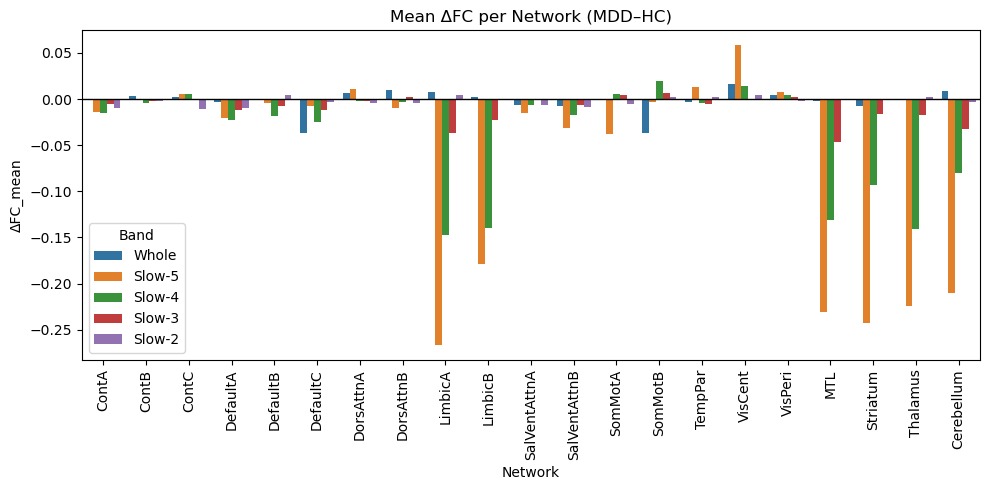

In [ ]:
summary = []
for band, subj_fcs in z_binned_netfcs.items():
    subs = list(subj_fcs.keys())
    group_labels = [groups[s] for s in subs]
    mdd = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "MDD"])
    hc  = np.array([subj_fcs[s] for s, g in zip(subs, group_labels) if g == "HC"])
    
    diff_mat = np.nanmean(mdd, axis=0) - np.nanmean(hc, axis=0)

    # Exclude self-connections
    diff_mat_no_diag = diff_mat.copy()
    np.fill_diagonal(diff_mat_no_diag, np.nan)

    mean_dfc = np.nanmean(diff_mat_no_diag, axis=1)
    
    df_band = pd.DataFrame({
        "Network": net_names_21,
        "ΔFC_mean": mean_dfc,
        "Band": band
    })
    summary.append(df_band)

summary_df = pd.concat(summary)

# plot per band
plt.figure(figsize=(10,5))
sns.barplot(data=summary_df, x="Network", y="ΔFC_mean", hue="Band")
plt.axhline(0, color='k', lw=1)
plt.xticks(rotation=90)
plt.title("Mean ΔFC per Network (MDD–HC)")
plt.tight_layout()
plt.show()

### Statistical analysis: Are slow bands more sensitive to group differences?

In [ ]:
### Network level test
bands_to_test = ["Slow-5", "Slow-4", "Slow-3", "Slow-2"]
net_results = []
for b in bands_to_test:
    res = compare_band_to_whole_network(summary_df, band=b, n_perm=10000, random_state=42)
    net_results.append(res)

# example: list of p-values from all tested bands
pvals = [res["p_perm"] for res in net_results]
bands = [res["band"] for res in net_results]

_, pvals_fdr = multipletests(pvals, method="fdr_bh")[:2]

for band, p, pfdr in zip(bands, pvals, pvals_fdr):
    # print results, p corrected
    print(f"{band:>7} p = {p:.4f},  p_FDR = {pfdr:.4f}, Cohen's d = {net_results[bands.index(band)]['cohen_d']:.4f}, Hedges' g = {net_results[bands.index(band)]['hedges_g']:.4f}")

 Slow-5 p = 0.0061,  p_FDR = 0.0192, Cohen's d = 0.6672, Hedges' g = 0.6405
 Slow-4 p = 0.0096,  p_FDR = 0.0192, Cohen's d = 0.6182, Hedges' g = 0.5935
 Slow-3 p = 0.3948,  p_FDR = 0.3948, Cohen's d = 0.1926, Hedges' g = 0.1849
 Slow-2 p = 0.1633,  p_FDR = 0.2177, Cohen's d = -0.3344, Hedges' g = -0.3210


### More analysis: Which specific networks contributed the most to that increase?

In [ ]:
### Networks where Slow-5 adds the most group-difference signal compared to wholeband.
drivers_slow5 = compute_slow_network_drivers(summary_df, band_label="Slow-5")

# Look at top 10 networks driving the Slow-5 > Whole difference
print(drivers_slow5[["Network",
                     "ΔFC_mean_Whole",
                     "ΔFC_mean_Slow-5",
                    #  "abs_whole",
                    #  "abs_band",
                     "d_abs",
                     "dir_Whole",
                     "dir_Slow"]].head(6))


      Network  ΔFC_mean_Whole  ΔFC_mean_Slow-5     d_abs dir_Whole dir_Slow5
0     LimbicA        0.008039        -0.266314  0.258275  MDD > HC  MDD < HC
1    Striatum       -0.008005        -0.242328  0.234323  MDD < HC  MDD < HC
2         MTL       -0.002073        -0.231319  0.229246  MDD < HC  MDD < HC
3    Thalamus        0.000305        -0.224676  0.224370  MDD > HC  MDD < HC
4  Cerebellum        0.008263        -0.209893  0.201630  MDD > HC  MDD < HC
5     LimbicB        0.002151        -0.179199  0.177048  MDD > HC  MDD < HC


In [ ]:
seed = "LimbicA"
band = "Slow-5"
limbica_slow_edges = get_network_edges(results_band, seed_network=seed, band_label=band)

print(limbica_slow_edges)
plot_network_edges(limbica_slow_edges, seed_network=seed, band_label=band)

      Connection       ΔFC    Band
0            MTL -2.143188  Slow-5
1       Thalamus -1.001473  Slow-5
2       Striatum -0.938119  Slow-5
3     Cerebellum -0.692148  Slow-5
4        LimbicB -0.324973  Slow-5
5   SalVentAttnB -0.108497  Slow-5
6       DefaultA -0.086011  Slow-5
7       DefaultC -0.060601  Slow-5
8   SalVentAttnA -0.055808  Slow-5
9        SomMotB -0.050095  Slow-5
10      DefaultB -0.041342  Slow-5
11         ContA -0.023746  Slow-5
12       SomMotA -0.012621  Slow-5
13         ContB  0.000809  Slow-5
14       TempPar  0.004329  Slow-5
15       VisPeri  0.010080  Slow-5
16         ContC  0.014253  Slow-5
17     DorsAttnB  0.022483  Slow-5
18     DorsAttnA  0.054973  Slow-5
19       VisCent  0.105425  Slow-5


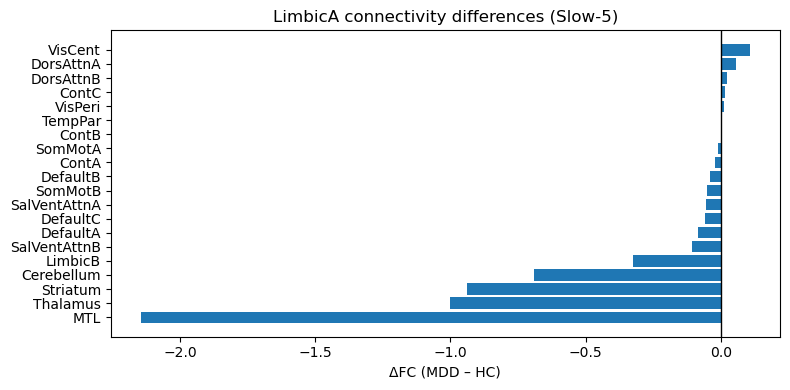